### `---------------Mandatory Information to fill------------`

### Group ID: 115
### Group Members Name with Student ID:
1. Samudrala Hari Chandana
2. Nikhil Yadav
3. Bollam Manindra
4. Suraj Anand


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks:
1. We considered the explore_count as 25 for each treatment (arm).
2. We are printing the state of the policies at 100th iteration as mentioned in the notebook (as opposed to Assignment, where every line printing as mentioned).

# Scenario

A pharmaceutical company is conducting clinical trials to evaluate the effectiveness of three antiretroviral drug combinations for treating HIV-positive patients. Due to the ethical and cost constraints of clinical trials, it is critical to identify the most effective treatment regimen using the least number of patients. Each treatment (or “arm”) can lead to different outcomes depending on patient responses. The effectiveness of each treatment is evaluated using a reward function derived from the improvement in patients’ immune system markers and survival status.



# Problem Definition

You are provided with a clinical dataset where each record corresponds to a patient, including the treatment they received and the resulting health outcomes. Your task is to simulate a clinical trial environment using various MAB strategies to sequentially recommend treatments and observe outcomes. The objective is to maximize the overall success rate across trials by identifying and favouring the most effective treatment.



# Dataset

You will be provided a dataset containing the following fields:

* ***Age (age)***: Patient's age in years at baseline.
* ***Weight (wtkg)***: Continuous feature representing weight in kilograms at baseline.
* ***Gender (gender)***: Binary indicator of gender (0 = Female, 1 = Male).
* ***CD4 Counts (cd40, cd420)***: Integer values representing CD4 counts at baseline and 20+/-5 weeks.
* ***Treatment Indicator (trt)***: Categorical feature indicating the type of treatment received (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only).
* ***Censoring Indicator (label)***: Binary indicator (1 = failure, 0 = censoring) denoting patient status.


***Link for accessing dataset:***
https://drive.google.com/file/d/1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-/view?usp=sharing


# Environment Setup

***Arms (Actions):*** The treatment types (trt)
* Arm 0: ZDV only
* Arm 1: ZDV + ddI
* Arm 2: ZDV + Zal
* Arm 3: ddI only


**Reward Function:**

Reward `r` is defined as:

`r = 1, if (label == 0) and (cd420 > cd40)`

`r = 0, otherwise`


  
This reward represents a successful treatment outcome as an increase in CD4 count and survival.

**Assumptions:**

*Number of Iterations:* Run the simulation for at least 1000 trials (iterations), with the option to extend the number of trials depending on the convergence behavior or observed reward trends. In each iteration, simulate one patient trial using one of the bandit policies.


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [37]:
# Constants
NUM_PATIENTS = 0
NUM_TRIALS = 1000
NUM_TREATMENTS = 4
TREATMENT_MAP = {
    0: "0_ZDV only",
    1: "1_ZDV + ddI",
    2: "2_ZDV + Zal",
    3: "3_ddI only"
}

# Load Dataset (0.5M)

In [38]:
# Importing required libraries
import numpy as np
import pandas as pd
import random
import gym

In [44]:
# Loading the Clinal Trial dataset
file_id='1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-'
url = f'https://drive.google.com/uc?id={file_id}'
clinical_trial_df = pd.read_csv(url)
clinical_trial_df = clinical_trial_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset Loaded:")
print(clinical_trial_df.head())

NUM_PATIENTS = len(clinical_trial_df)
print(f"Number of Patients: {NUM_PATIENTS}")

Dataset Loaded:
   age      wtkg  gender  cd40  cd420  trt  label
0   41  81.60000       1   210    210    0      0
1   53  91.00000       1   378    393    0      1
2   33  74.98008       1   252    225    0      0
3   27  55.33920       0   234    293    1      0
4   22  71.66880       1   257    275    1      0
Number of Patients: 2139


# Design a Clinical Trial Environment (0.5M)

In [41]:
class MultiArmedBanditEnv(gym.Env):
  
  def __init__(self, clinic_trial_df):
    self.clinic_trial_df = clinic_trial_df
    self.policy_state = {}
    self.current_patient_idx = 0
    self.reset()

  # Reward Function
  def calc_rewards(self, treatment):
    if self.current_patient_idx  >= NUM_PATIENTS:
      raise IndexError("No more patients available.")
    patient_record = self.clinic_trial_df.loc[self.current_patient_idx]
    if patient_record['trt'] == treatment and patient_record['label'] == 0 and patient_record['cd420'] > patient_record['cd40']:
      rewards = 1
    else : rewards = 0 
    self.policy_state[treatment].append(rewards)
    self.current_patient_idx += 1
    return self.policy_state, rewards

  # Reset the Environment after each policy run
  def reset(self):
    self.policy_state = {} #{0:[0,1,0,0,..1000th],1:[],2:[],3:[]}
    self.current_patient_idx = 0
    for i in TREATMENT_MAP.keys():
      self.policy_state[i] = []
    return self.policy_state

  # Render the Environment for each policy
  def render(self, policy_used):
    print(f"========SUMMARY OF {policy_used}========")
    rewards = {}
    trials = {}
    for i in range(NUM_TREATMENTS):
      rewards[i] = sum(self.policy_state[i])
      trials[i] = len(self.policy_state[i])
    print(f'--------Total Trials: {sum(trials.values())}--------')
    for b, r in rewards.items():
      t = trials[b]
      print(f'Treatment {b} | Rewards: {r}, Trials conducted: {t}')
    print(f'--------Total Rewards for the Policy: {sum(rewards.values())}--------\n')
    if policy_used == "EPSILON-GREEDY POLICY":
      return sum(rewards.values())


def get_clinical_trial_env():
  return MultiArmedBanditEnv(clinical_trial_df)

# Using Random Policy (0.5M)
Implement a random policy for treatment selection and print each 100th iteration. (Mandatory)

In [43]:
if __name__ == '__main__':
  env = get_clinical_trial_env()
  policy_state = env.reset()
  total_rewards = 0
  #plotting
  random_policy_rewards_list = []
  random_treatment_selection_counts_map = {}

  print("========TRIALS STARTED========")
  for i in range(1,NUM_TRIALS+1):
    random_treatment = random.randint(0,NUM_TREATMENTS-1)
    policy_state, curr_rewards = env.calc_rewards(random_treatment)
    total_rewards += curr_rewards
    random_policy_rewards_list.append(curr_rewards)
    if(i%100 == 0):
      print(f"--------At Trial {i}--------")
      print(f"Treatment Selected Randomly: {random_treatment} | Total Rewards: {total_rewards}")
  print("========TRIALS ENDED========\n")
  
  #For Plotting purpose
  random_treatment_selection_counts_map = {treatment: len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)}
  
  env.render("RANDOM POLICY")
  env.close()

========TRIALS STARTED========
--------At Trial 100--------
Treatment Selected Randomly: 2 | Total Rewards: 10
--------At Trial 200--------
Treatment Selected Randomly: 3 | Total Rewards: 18
--------At Trial 300--------
Treatment Selected Randomly: 3 | Total Rewards: 32
--------At Trial 400--------
Treatment Selected Randomly: 0 | Total Rewards: 45
--------At Trial 500--------
Treatment Selected Randomly: 1 | Total Rewards: 52
--------At Trial 600--------
Treatment Selected Randomly: 1 | Total Rewards: 62
--------At Trial 700--------
Treatment Selected Randomly: 0 | Total Rewards: 71
--------At Trial 800--------
Treatment Selected Randomly: 1 | Total Rewards: 85
--------At Trial 900--------
Treatment Selected Randomly: 3 | Total Rewards: 97
--------At Trial 1000--------
Treatment Selected Randomly: 2 | Total Rewards: 106
========TRIALS ENDED========

========SUMMARY OF RANDOM POLICY========
--------Total Trials: 1000--------
Treatment 0 | Rewards: 15, Trials conducted: 257
Treatment 1 

# Using Greedy Policy (1M)
Implement the Greedy policy that always selects the treatment with the highest average reward and print each 100th iteration. (Mandatory)

In [62]:
#We considered initial exploration phase of 25 trials, i.e., 25*4 = 100 trials out of 1000 for Inital Exploration
def greedy_policy(policy_state, explore_trials = 25):
  #Inital Policy state: {0:[],1:[],2:[],3:[]}
  clinical_trials_done = sum([len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)])
  total_trials_to_explore = NUM_TREATMENTS * explore_trials

  # Exploration Phase
  if clinical_trials_done < total_trials_to_explore:
    if(clinical_trials_done == 0):
      print(f"--------Exploration Started--------")
      for treatment, rewards in policy_state.items():
        print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")
    return clinical_trials_done % NUM_TREATMENTS
  elif clinical_trials_done == total_trials_to_explore:
    print(f"--------Exploration Ended--------")
    for treatment, rewards in policy_state.items():
      print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")

  # Exploitation Phase
  avg_rewards = [sum(policy_state[treatment]) / len(policy_state[treatment]) for treatment in  range(NUM_TREATMENTS)]
  best_treatment = np.argmax(avg_rewards)
  return best_treatment


def run_greedy_policy(env):
  policy_state = env.reset()
  total_rewards = 0
  greedy_policy_rewards_list = []
  print("========TRIALS STARTED========")
  for i in range(1,NUM_TRIALS+1):
    treatment_selected = greedy_policy(policy_state)
    policy_state, curr_rewards = env.calc_rewards(treatment_selected)
    total_rewards += curr_rewards
    greedy_policy_rewards_list.append(curr_rewards)
    if i == 101:
        print("\n--------Exploitation Started--------")
    if(i%100 == 0 and i != 100):
      print(f"--------Treatment Selected Greedily: {treatment_selected}--------")
      for treatment, rewards in policy_state.items():
        print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")
      print(f"At Trial {i} | Total Rewards: {total_rewards}")
  print("--------Exploitation Ended--------")
  print("========TRIALS ENDED========\n")
  return greedy_policy_rewards_list,policy_state


In [51]:
if __name__ == '__main__':
  env = get_clinical_trial_env()
  greedy_treatment_selection_counts_map = {}
  greedy_policy_rewards_list,policy_state = run_greedy_policy(env)
  # For Plotting purpose
  greedy_treatment_selection_counts_map = {treatment: len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)}
  env.render("GREEDY POLICY")
  env.close()

========TRIALS STARTED========
--------Exploration Started--------
Treatment 0 | Rewards: 0, Trials conducted: 0
Treatment 1 | Rewards: 0, Trials conducted: 0
Treatment 2 | Rewards: 0, Trials conducted: 0
Treatment 3 | Rewards: 0, Trials conducted: 0
--------Exploration Ended--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Treatment 1 | Rewards: 7, Trials conducted: 25
Treatment 2 | Rewards: 3, Trials conducted: 25
Treatment 3 | Rewards: 2, Trials conducted: 25

--------Exploitation Started--------
--------Treatment Selected Greedily: 1--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Treatment 1 | Rewards: 17, Trials conducted: 125
Treatment 2 | Rewards: 3, Trials conducted: 25
Treatment 3 | Rewards: 2, Trials conducted: 25
At Trial 200 | Total Rewards: 23
--------Treatment Selected Greedily: 1--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Treatment 1 | Rewards: 32, Trials conducted: 225
Treatment 2 | Rewards: 3, Trials conducted: 25
Treatment 3 | Rewards: 2, Tri

# Using Epsilon-Greedy Policy (1.5M)
Implement the ε-Greedy policy with ε = 0.1, 0.2, 0.5. Report iteration-wise selections and rewards. Determine which ε yields the best result. (Mandatory)

In [75]:
import random

#We considered initial exploration phase of 25 trials, i.e., 25*4 = 100 trials out of 1000 for Inital Exploration
def e_greedy_policy(i, policy_state, epsilon_value, epsilon_count=0,explore_trials_per_treatment = 25):
  total_trials_to_explore = NUM_TREATMENTS * explore_trials_per_treatment #100
  total_epsilon_trials_to_explore = int(epsilon_value * (NUM_TRIALS - total_trials_to_explore)) #0.1 (1000-100) = 90
  # Calculate Exploration points
  exploration_points = np.unique(np.linspace(total_trials_to_explore+1, NUM_TRIALS, total_epsilon_trials_to_explore,dtype=int))

  # Initial Exploration
  clinical_trials_done = sum([len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)])
  if clinical_trials_done < total_trials_to_explore:
    return clinical_trials_done % NUM_TREATMENTS,epsilon_count, exploration_points
  
  #Exploration at scheduled trials by selecting random treatment
  if (i in exploration_points) and (epsilon_count < total_epsilon_trials_to_explore):
    epsilon_count += 1
    return random.randint(0, NUM_TREATMENTS - 1),epsilon_count, exploration_points

  # Exploitation at all other Trials
  avg_rewards = [sum(policy_state[treatment]) / len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)]
  best_treatment = np.argmax(avg_rewards)

  return best_treatment,epsilon_count, exploration_points


def run_e_greedy_policy(env, epsilon_value):
  policy_state = env.reset()
  total_rewards = 0
  epsilon_count = 0
  exploration_points = []
  e_greedy_policy_rewards_list = []
  treatment_selected = None
  
  for i in range(1,NUM_TRIALS+1):
    print_progress(i,treatment_selected,policy_state,exploration_points,total_rewards)
    treatment_selected, epsilon_count, exploration_points = e_greedy_policy(i, policy_state, epsilon_value, epsilon_count)
    policy_state, curr_rewards = env.calc_rewards(treatment_selected)
    total_rewards += curr_rewards
    e_greedy_policy_rewards_list.append(curr_rewards)
  return e_greedy_policy_rewards_list, policy_state

def print_progress(i,treatment_selected,policy_state,exploration_points,total_rewards):
    if(i==1):
      print("========TRIALS STARTED========")
    if(i<=100):
      if(i==1):
        print("--------Inital Exploration Started--------")
        for treatment, rewards in policy_state.items():
          print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")
        print(f"Total Rewards: {total_rewards}")
      elif(i==100):
        print("--------Inital Exploration Ended--------")
        for treatment, rewards in policy_state.items():
          print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")
        print(f"Total Rewards: {total_rewards}")
        print("--------Exploitation Started--------")
    if(i > 100 and (i%100 == 0 or i in exploration_points)):
      if(i in exploration_points):
        print(f"--------Scheduled Exploration at, {i}--------")
        print(f"--------Treatment Selected Randomly: {treatment_selected}--------")
      else:
        print(f"--------Exploitation at, {i}--------")
        print(f"--------Treatment Selected Greedily: {treatment_selected}--------")
      for treatment, rewards in policy_state.items():
        print(f"Treatment {treatment} | Rewards: {sum(rewards)}, Trials conducted: {len(rewards)}")
      print(f"Total Rewards: {total_rewards}")
    if(i==NUM_TRIALS):
      print("--------Exploitation Ended--------")
      print("========TRIALS ENDED========\n")

In [82]:
if __name__ == '__main__':
  env = get_clinical_trial_env()
  policy_state = env.reset()
  e_greedy_treatment_selection_counts_map = {}
  epsilon_values = [0.1,0.2,0.5]
  epsilon_rewards = {}
  for epsilon_value in epsilon_values:
    e_greedy_policy_rewards_list, policy_state = run_e_greedy_policy(env,epsilon_value)
    e_greedy_treatment_selection_counts_map = {treatment: len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)}
    print(f"--------Epsilon Value: {epsilon_value}--------")
    epsilon_rewards[epsilon_value] = env.render("EPSILON-GREEDY POLICY")
  env.close()

  print("******** Epsilon Value vs Total Rewards  ********")
  for e,result in epsilon_rewards.items():
    print(f"Epsilon Value: {e} | Total Rewards: {result}")

  print("\n-------------------------------------------------------------------------")
  print("Epsilon Value 0.1 yields best results for the Clinical Trial Environment")
  print("-------------------------------------------------------------------------")

========TRIALS STARTED========
--------Inital Exploration Started--------
Treatment 0 | Rewards: 0, Trials conducted: 0
Treatment 1 | Rewards: 0, Trials conducted: 0
Treatment 2 | Rewards: 0, Trials conducted: 0
Treatment 3 | Rewards: 0, Trials conducted: 0
Total Rewards: 0
--------Inital Exploration Ended--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Treatment 1 | Rewards: 7, Trials conducted: 25
Treatment 2 | Rewards: 3, Trials conducted: 25
Treatment 3 | Rewards: 2, Trials conducted: 24
Total Rewards: 13
--------Exploitation Started--------
--------Scheduled Exploration at, 101--------
--------Treatment Selected Randomly: 3--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Treatment 1 | Rewards: 7, Trials conducted: 25
Treatment 2 | Rewards: 3, Trials conducted: 25
Treatment 3 | Rewards: 2, Trials conducted: 25
Total Rewards: 13
--------Scheduled Exploration at, 111--------
--------Treatment Selected Randomly: 1--------
Treatment 0 | Rewards: 1, Trials conducted: 25
Tr

# Using UCB (1M)
Implement the UCB algorithm for treatment selection and print each 100th iteration. (Mandatory)

In [34]:
def ucb_policy(policy_state, t):
    avg_rewards = [
        sum(policy_state[b]) / len(policy_state[b]) if len(policy_state[b]) > 0 else 0
        for b in range(NUM_TREATMENTS)
    ]

    # Add confidence bounds for exploration
    confidence_bounds = [
        avg_rewards[b] + np.sqrt((2 * np.log(t + 1)) / len(policy_state[b]))
        if len(policy_state[b]) > 0 else float('inf')  # Handle unvisited treatments
        for b in range(NUM_TREATMENTS)
    ]
    best_treatment = np.argmax(confidence_bounds)
    return best_treatment

def run_ucb_policy(env):
    policy_state = env.reset()
    total_rewards = 0
    ucb_policy_rewards_list = []
    print("========TRIALS STARTED========")
    for i in range(1,NUM_TRIALS+1):
        treatment_selected = ucb_policy(policy_state,i)
        policy_state, curr_rewards = env.calc_rewards(treatment_selected)
        total_rewards += curr_rewards
        ucb_policy_rewards_list.append(curr_rewards)
        if(i%100 == 0):
            print(f"--------At Trial {i}--------")
            print(f"Treatment Selected UCB: {treatment_selected} | Total Rewards: {total_rewards}")
    print("========TRIALS ENDED========")
    return env,ucb_policy_rewards_list,policy_state

In [35]:
if __name__ == '__main__':
  policy_state = env.reset()
  env = get_clinical_trial_env()
  ucb_treatment_selection_counts_map = {}
  env,ucb_policy_rewards_list,policy_state = run_ucb_policy(env)
  ucb_treatment_selection_counts_map = {treatment: len(policy_state[treatment]) for treatment in range(NUM_TREATMENTS)}
  env.render("UCB POLICY")
  env.close()

========TRIALS STARTED========
--------At Trial 100--------
Treatment Selected UCB: 2 | Total Rewards: 21
--------At Trial 200--------
Treatment Selected UCB: 2 | Total Rewards: 33
--------At Trial 300--------
Treatment Selected UCB: 1 | Total Rewards: 53
--------At Trial 400--------
Treatment Selected UCB: 2 | Total Rewards: 67
--------At Trial 500--------
Treatment Selected UCB: 0 | Total Rewards: 78
--------At Trial 600--------
Treatment Selected UCB: 2 | Total Rewards: 88
--------At Trial 700--------
Treatment Selected UCB: 3 | Total Rewards: 98
--------At Trial 800--------
Treatment Selected UCB: 2 | Total Rewards: 114
--------At Trial 900--------
Treatment Selected UCB: 1 | Total Rewards: 126
--------At Trial 1000--------
Treatment Selected UCB: 1 | Total Rewards: 137
========TRIALS ENDED========
========SUMMARY OF UCB POLICY========
--------Total Trials: 1000--------
Treatment 0 | Rewards: 14, Trials conducted: 169
Treatment 1 | Rewards: 50, Trials conducted: 310
Treatment 2 | R

# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)

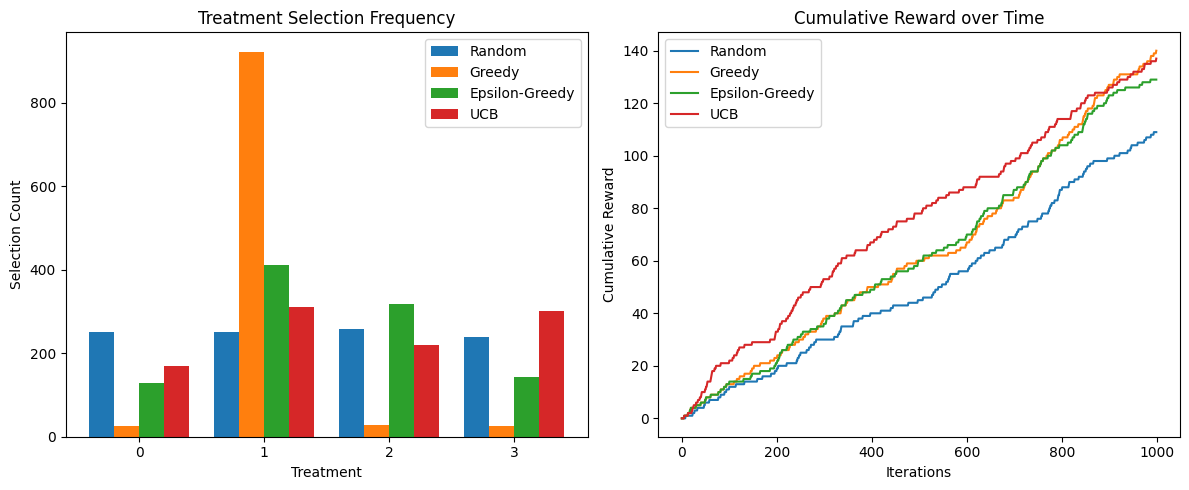

In [36]:
import matplotlib.pyplot as plt
import numpy as np

random_cumm_rewards = np.cumsum(random_policy_rewards_list)
greedy_cumm_rewards = np.cumsum(greedy_policy_rewards_list)
e_greedy_cumm_rewards = np.cumsum(e_greedy_policy_rewards_list)
ucb_cumm_rewards = np.cumsum(ucb_policy_rewards_list)

# --- Plotting ---
arms = list(random_treatment_selection_counts_map.keys())

plt.figure(figsize=(12, 5))

# --- Plot 1: Arm Selection Frequency ---
plt.subplot(1, 2, 1)
bar_width = 0.2
index = np.arange(len(arms))

plt.bar(index, [random_treatment_selection_counts_map[a] for a in arms], width=bar_width, label='Random')
plt.bar(index + bar_width, [greedy_treatment_selection_counts_map[a] for a in arms], width=bar_width, label='Greedy')
plt.bar(index + 2*bar_width, [e_greedy_treatment_selection_counts_map[a] for a in arms], width=bar_width, label='Epsilon-Greedy')
plt.bar(index + 3*bar_width, [ucb_treatment_selection_counts_map[a] for a in arms], width=bar_width, label='UCB')

plt.xlabel('Treatment')
plt.ylabel('Selection Count')
plt.title('Treatment Selection Frequency')
plt.xticks(index + 1.5 * bar_width, arms)
plt.legend()

# --- Plot 2: Cumulative Rewards ---
plt.subplot(1, 2, 2)
plt.plot(random_cumm_rewards, label='Random')
plt.plot(greedy_cumm_rewards, label='Greedy')
plt.plot(e_greedy_cumm_rewards, label='Epsilon-Greedy')
plt.plot(ucb_cumm_rewards, label='UCB')

plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusion (0.5M)

write a conclusion (approximately 250 words) summarizing which treatment policy was most effective. Discuss the balance between exploration and exploitation in your simulations.

`----write below this line------`